### Etape 1 : Extraction du diagraph à partir du json + Création des 1ères features :

In [1]:
import os

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier

dotenv.load_dotenv()

True

In [2]:
train_path = os.environ["TRAIN_PATH"]
data_folder = os.environ["DATA_FOLDER"]

In [3]:
all_test = pd.read_csv(f'{data_folder}/all_test_degree.csv')
all_df = pd.read_csv(f'{data_folder}/all_df_degree.csv')

In [4]:
list_col_new = [
    "name", 'cyclomatic_complexity', 'density',
    'label_entropy', 'ratio_call_ret', 'ratio_conditional',
    'num_entry_nodes', 'num_exit_nodes', 'suspicious_sequence_count',
    'max_consecutive_JCC', 'ngram_entropy'
]

In [5]:
# On ne garde uniquement les colonnes qui sont nouvelles
df_features_new = pd.read_json(f"{data_folder}/df_features_train.json", lines=True)[list_col_new]
df_features_test_new = pd.read_json(f"{data_folder}/df_feature_test.json", lines=True)[list_col_new]

In [6]:
all_df = all_df.merge(df_features_new, how='left', on="name")
all_test = all_test.merge(df_features_test_new, how='left', on="name")

In [7]:
df_content_train = pd.read_csv(f"{data_folder}/content_features_train.csv")[['name', 'compressed_length', 'compression_ratio']]
df_content_test = pd.read_csv(f"{data_folder}/content_features_test.csv")[['name', 'compressed_length', 'compression_ratio']]

In [8]:
all_df = all_df.merge(df_content_train, how='left', on="name")
all_test = all_test.merge(df_content_test, how='left', on="name")

In [9]:
all_df

,name,file_size,num_nodes,num_edges,num_loops,num_calls,num_jumps,num_ret,num_conditional_jumps,average_out_degree,...,label_entropy,ratio_call_ret,ratio_conditional,num_entry_nodes,num_exit_nodes,suspicious_sequence_count,max_consecutive_JCC,ngram_entropy,compressed_length,compression_ratio
0,000288eb820d08011f1f5a379d3ac38e3a4bf679777c2f...,103576,1112,1740,14,270,230,69,428,1.564748,...,1.443114,3.857143,0.384892,12,70,0,11,4.057058,20365.0,5.226074
1,000299f0baee15daa295b45083f32f0183c25948efdb88...,15984,161,245,4,6,21,4,84,1.521739,...,1.205597,1.200000,0.521739,3,6,0,5,3.120338,3250.0,5.043385
2,0006f473314630a3a3089e4cf00e34b055d24dc8f82717...,303471,4607,7413,3,2485,641,470,526,1.609073,...,1.357169,5.276008,0.114174,289,483,18,3,3.850158,70874.0,4.451449
3,00090d289035749bdd0a25ad1990be32b12e3d1ae03bc5...,11229717,102070,182474,65,60104,4938,3941,24487,1.787734,...,1.147982,15.247083,0.239904,3945,4187,53,13,3.171141,1846316.0,6.236344
4,000a3c574c875d19538eb58a9aca407f3a7db5f7d561b4...,3728521,42349,64677,88,13625,3474,3590,13004,1.527238,...,1.536203,3.794208,0.307067,3676,4661,19,15,4.330151,731419.0,5.244057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23251,6644e70909b02c3e774ad35b1ec1cf6944ebf8e1ab0590...,313243,2815,3251,0,2,1,3,490,1.154885,...,0.493995,0.500000,0.174067,1,22,0,4,1.480769,45499.0,7.018704
23252,6645199527f05d5d288d6628276d2fea6c5a97d6f028b4...,18379,295,476,0,182,13,44,44,1.613559,...,1.125802,4.044444,0.149153,16,45,2,2,3.183565,4359.0,4.393439
23253,66499cda0ecf663375bd67e42255e678d77405e4016010...,3590439,42762,49884,0,2856,1408,856,5032,1.166550,...,0.841158,3.332555,0.117675,375,918,0,2,2.426335,691789.0,5.324014
23254,664e76facf35544b455800a23dec85085a3e047158b704...,55570,586,692,4,34,19,31,207,1.180887,...,1.556608,1.062500,0.353242,100,135,0,6,4.530103,12054.0,4.716194


### Add tfidf

In [10]:
all_count = pd.read_csv(f'{data_folder}/all_count.csv')
all_test_count = pd.read_csv(f'{data_folder}/all_test_count.csv')

In [11]:
all_count_name = all_count['name']
all_count = all_count.drop('name', axis=1)

all_count_tf = all_count.div(all_count.sum(axis=1)+1, axis=0)

weight_idf = np.log(all_count.shape[0]/(all_count>0).sum(axis=0))
all_count_tf_idf = all_count_tf.mul(weight_idf)

final_count = pd.concat([all_count_name, all_count_tf_idf], axis=1)

In [12]:
all_test_count_name = all_test_count['name']
all_test_count = all_test_count.drop('name', axis=1)

all_test_count_tf = all_test_count.div(all_test_count.sum(axis=1)+1, axis=0)

all_test_count_tf_idf = all_test_count_tf.mul(weight_idf)

final_test_count = pd.concat([all_test_count_name, all_test_count_tf_idf], axis=1)

In [13]:
all_df = all_df.merge(final_count, on="name", how="inner")
all_test = all_test.merge(final_test_count, on="name", how="inner")

In [14]:
drop_cols = ['name', 'average_out_degree', 'min_out_degree', 'min_in_degree']

### Add target

In [15]:
target = pd.read_csv(f"{data_folder}/training_set_metadata.csv", sep=";")
target_col = list(target.drop('name', axis=1).columns)
all_df_with_target = all_df.merge(target, how='inner', on="name")

### Model

In [16]:
model_col = list(all_df_with_target.drop(target_col+drop_cols, axis=1).columns)

X = all_df_with_target[model_col]
y = all_df_with_target.drop(model_col+drop_cols, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [38]:
# best length = 410
# This code allow to keep all "graph" variables, as they are not frequently 0, and then filter tfidf columns base on document frequency (as done in sklearn)
# length 150, 410, 81²2 and 1200 was tested, 410 has the best result, 812 was close.
# Maybe a value between could improve the result
features = list((X>0).sum(axis=0).sort_values(ascending=False).iloc[0:290].index)

### F1 score (do not use for submission)

In [39]:
gb_model = HistGradientBoostingClassifier(
    validation_fraction=None,
    learning_rate=0.25,
    max_depth=8,
    max_iter=400,
    max_leaf_nodes=53,
    max_features=0.7,
    min_samples_leaf=140,
    class_weight="balanced",
    l2_regularization=0.5
)

best_model = OneVsRestClassifier(gb_model, verbose=10)
best_model.fit(X[features], y)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   19.3s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:   49.2s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  4.6min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  5.5min
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:  6.8min
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:  7.6min
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:  9.6min
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed: 10.5min
[Parallel(n_jobs=1)]: Done 112 tasks      | elapsed: 12.2min
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed: 13.5min
[Parallel(n_jobs=1)]: Done 144 tasks      | elapsed: 14.4min
[Parallel(n_jobs=1)]: Do

OneVsRestClassifier(estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                             l2_regularization=0.5,
                                                             learning_rate=0.25,
                                                             max_depth=8,
                                                             max_features=0.7,
                                                             max_iter=400,
                                                             max_leaf_nodes=53,
                                                             min_samples_leaf=140,
                                                             validation_fraction=None),
                    verbose=10)

In [44]:
# --- Évaluation du modèle ---
from sklearn.metrics import classification_report, accuracy_score
y_pred = single_model.predict(X_train[features])

accuracy = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred, average='macro')

print("Accuracy globale moyenne :", accuracy)
print("F1 score global (macro) :", f1)
print("\nClassification report global :")

Accuracy globale moyenne : 0.7964207261920144
F1 score global (macro) : 0.9715489659447545

Classification report global :


c:\Users\doria\Documents\Mathilde\sdc_msiac\sdc_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
y_pred = single_model.predict(X_test[features])

# --- Évaluation du modèle ---
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy globale moyenne :", accuracy)
print("F1 score global (macro) :", f1)
print("\nClassification report global :")

report = classification_report(y_test, y_pred, output_dict=True)

df_report = pd.DataFrame(report).transpose()

df_report_sorted = df_report.sort_values(by='f1-score', ascending=False)

print(df_report_sorted)

# best = 0.48688016203854123 250
# ancien best = 0.48402718683877116

Accuracy globale moyenne : 0.08328961175236096
F1 score global (macro) : 0.4876155816946489

Classification report global :
     precision  recall  f1-score  support
198        1.0     1.0       1.0      1.0
324        1.0     1.0       1.0      2.0
321        1.0     1.0       1.0      2.0
137        1.0     1.0       1.0      2.0
314        1.0     1.0       1.0      1.0
..         ...     ...       ...      ...
275        0.0     0.0       0.0      1.0
277        0.0     0.0       0.0      3.0
283        0.0     0.0       0.0      7.0
44         0.0     0.0       0.0      0.0
313        0.0     0.0       0.0      1.0

[457 rows x 4 columns]


c:\Users\doria\Documents\Mathilde\sdc_msiac\sdc_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\doria\Documents\Mathilde\sdc_msiac\sdc_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\doria\Documents\Mathilde\sdc_msiac\sdc_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

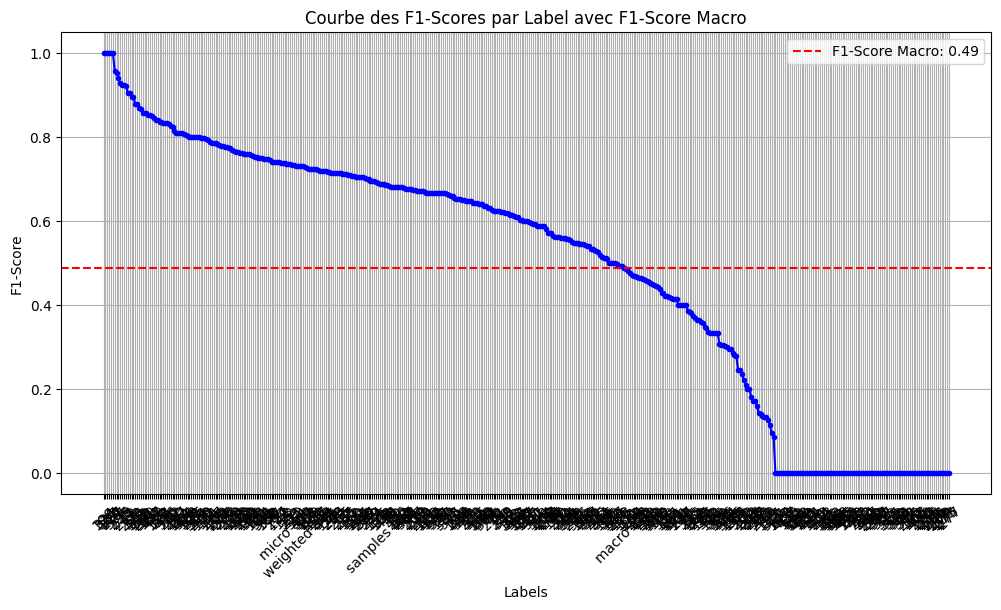

In [46]:
# Extraire les labels et les F1-scores
labels = df_report_sorted.index[:-3]
f1_scores = df_report_sorted.loc[labels, 'f1-score']
f1_macro = df_report.loc['macro avg', 'f1-score']
# Tracer la courbe des F1-scores par label
plt.figure(figsize=(12, 6))
plt.plot(labels, f1_scores, marker='.', color='b')
plt.axhline(y=f1_macro, color='r', linestyle='--', label=f'F1-Score Macro: {f1_macro:.2f}')
plt.title('Courbe des F1-Scores par Label avec F1-Score Macro')
plt.xlabel('Labels')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_report["comportement"] = y.columns.to_list() + ["micro avg","macro avg","weighted avg","samples avg"]
df_report

In [ ]:
df_report.to_csv("f1_score.csv")

### Grid search hgb

In [31]:
X[features]

,compressed_length,file_size,compression_ratio,max_out_degree,ngram_entropy,label_entropy,density,average_degree_connectivity,max_in_degree,average_in_degree,...,fldenv,fninit,cpuid,ucomiss,frstor,pand,comiss,fdivrp,movlpd,cvtps2pd
0,20365.0,103576,5.226074,2,4.057058,1.443114,0.001408,0.036533,77,1.564748,...,0.002079,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,3250.0,15984,5.043385,2,3.120338,1.205597,0.009511,0.074013,17,1.521739,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,70874.0,303471,4.451449,56,3.850158,1.357169,0.000349,0.116233,1054,1.609073,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,1846316.0,11229717,6.236344,2,3.171141,1.147982,0.000018,0.789843,51208,1.787734,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,731419.0,3728521,5.244057,39,4.330151,1.536203,0.000036,0.026286,2081,1.527238,...,0.000000,0.000055,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23097,45499.0,313243,7.018704,2,1.480769,0.493995,0.000410,0.002062,4,1.154885,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
23098,4359.0,18379,4.393439,2,3.183565,1.125802,0.005488,0.505134,161,1.613559,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
23099,691789.0,3590439,5.324014,32,2.426335,0.841158,0.000027,0.000933,421,1.166550,...,0.000000,0.000000,0.0,0.0,0.000055,0.0,0.0,0.000113,0.0,0.0
23100,12054.0,55570,4.716194,2,4.530103,1.556608,0.002019,0.023560,45,1.180887,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


First cell is without gridsearch, second is with gridsearch (the prefered option), only run one of them

In [ ]:
# Run this is you only what to try one new set of parameters and submit it without gridsearch validation, it is quicker

# gb_model = HistGradientBoostingClassifier(
#     validation_fraction=None,
#     learning_rate=0.25,
#     max_depth=8,
#     max_iter=400,
#     max_leaf_nodes=53,
#     max_features=0.8,
#     min_samples_leaf=140,
#     class_weight="balanced"
# )


# best_model = OneVsRestClassifier(gb_model, verbose=10)
# best_model.fit(X[features], y)

In [33]:
# Run this for the gridsearch variant, could work with only one combinaison
# As of now, the best mean_test_score i have obtained is 0.491256
# Every time I inscreased this metric, the submission score has improved, so it is a good judge
# validation_fraction is at none because hgb use stratify split. It could be possible to remove the label with only one occurence and just predict 0.
# A validation fraction at 0.1 could reduce overfitting

gb_model = HistGradientBoostingClassifier(validation_fraction=None)

# Wrap in OneVsRestClassifier for multi-label classification
multi_label_model = OneVsRestClassifier(gb_model)

param_grid = {
    "estimator__learning_rate": [0.25],
    "estimator__max_depth": [8],
    "estimator__max_iter": [400],
    "estimator__max_leaf_nodes": [31, 53],
    "estimator__max_features": [0.7],
    "estimator__min_samples_leaf": [140, 150],
    "estimator__class_weight": ["balanced"],
    "estimator__l2_regularization": [0.05, 0.5]
}

scorer = make_scorer(f1_score, average="macro")

grid_search = GridSearchCV(multi_label_model, param_grid, scoring=scorer, cv=3, verbose=4, n_jobs=-1)
grid_search.fit(X[features], y)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'estimator__class_weight': 'balanced', 'estimator__l2_regularization': 0.5, 'estimator__learning_rate': 0.25, 'estimator__max_depth': 8, 'estimator__max_features': 0.7, 'estimator__max_iter': 400, 'estimator__max_leaf_nodes': 53, 'estimator__min_samples_leaf': 140}


In [35]:
results = pd.DataFrame(grid_search.cv_results_)

results[['params', 'mean_test_score', 'rank_test_score']].sort_values('mean_test_score', ascending=False).iloc[0:20]

,params,mean_test_score,rank_test_score
6,"{'estimator__class_weight': 'balanced', 'estim...",0.496036,1
4,"{'estimator__class_weight': 'balanced', 'estim...",0.494893,2
7,"{'estimator__class_weight': 'balanced', 'estim...",0.494636,3
0,"{'estimator__class_weight': 'balanced', 'estim...",0.493019,4
5,"{'estimator__class_weight': 'balanced', 'estim...",0.492699,5
3,"{'estimator__class_weight': 'balanced', 'estim...",0.492612,6
1,"{'estimator__class_weight': 'balanced', 'estim...",0.492410,7
2,"{'estimator__class_weight': 'balanced', 'estim...",0.491653,8


In [38]:
results.loc[6, "params"]

{'estimator__class_weight': 'balanced',
 'estimator__l2_regularization': 0.5,
 'estimator__learning_rate': 0.25,
 'estimator__max_depth': 8,
 'estimator__max_features': 0.7,
 'estimator__max_iter': 400,
 'estimator__max_leaf_nodes': 53,
 'estimator__min_samples_leaf': 140}

In [53]:
# Extraire les meilleurs paramètres pour chaque sous-modèle (chaque label)
best_params_per_label = {}
for idx, estimator in enumerate(best_model.estimators_):
    best_params_per_label[f"Label_{idx}"] = estimator.get_params()

# Afficher les meilleurs paramètres par sous-modèle
for label, params in best_params_per_label.items():
    # print(f"\nMeilleurs paramètres pour {label}:")
    for key, value in params.items():
        if "max_features" in key:  # Filtrer les hyperparamètres pertinents
            if value == 0.8:
                print(f"  {key}: {value}")

### Shap

In [60]:
f1_score = pd.read_csv('f1_score.csv')
best_models = f1_score[(f1_score["f1-score"] > 0.8) & (f1_score["f1-score"] < 0.9)]

In [61]:
best_models

,Unnamed: 0,precision,recall,f1-score,support,comportement
2,2,0.824064,0.844186,0.834003,860.0,PEB access
11,11,0.835714,0.800000,0.817467,585.0,allocate thread local storage
27,27,0.825698,0.846506,0.835973,873.0,calculate modulo 256 via x86 assembly
30,30,0.777778,0.848485,0.811594,33.0,capture screenshot in Go
43,43,1.000000,0.755556,0.860759,45.0,check for VM using instruction VPCEXT
59,59,0.810526,0.847188,0.828452,1636.0,check if file exists
99,99,0.851166,0.864206,0.857636,1436.0,create or open file
105,105,0.911392,0.727273,0.808989,198.0,create process suspended
125,125,0.846154,0.897959,0.871287,98.0,decrypt data using AES via x86 extensions
128,128,0.834483,0.914148,0.872501,1456.0,delay execution


In [62]:
best_model.estimators_

[HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.25,
                                max_depth=8, max_features=0.7, max_iter=400,
                                max_leaf_nodes=53, min_samples_leaf=140,
                                validation_fraction=None),
 HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.25,
                                max_depth=8, max_features=0.7, max_iter=400,
                                max_leaf_nodes=53, min_samples_leaf=140,
                                validation_fraction=None),
 HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.25,
                                max_depth=8, max_features=0.7, max_iter=400,
                                max_leaf_nodes=53, min_samples_leaf=140,
                                validation_fraction=None),
 HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.25,
                                max_depth=8, max_features=0.7, ma

c:\Users\doria\Documents\Mathilde\sdc_msiac\sdc_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 22990/23102 [02:21<00:00]        

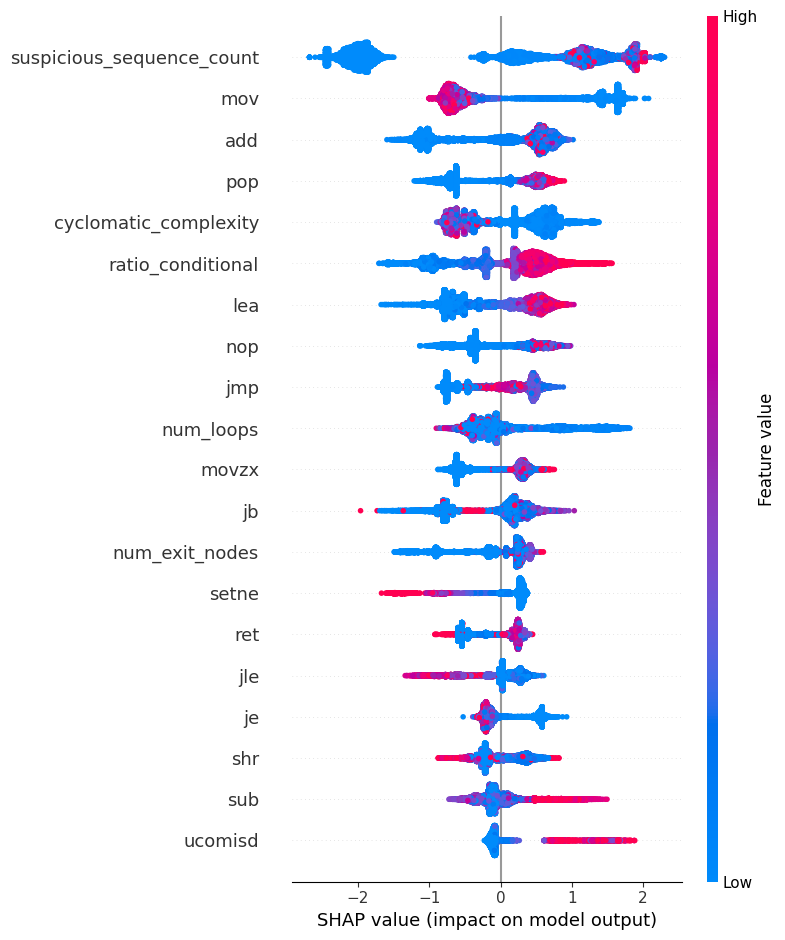

In [63]:
import shap

first_label_classifier = best_model.estimators_[best_models.index[0]]

# Appliquer SHAP
explainer = shap.Explainer(first_label_classifier, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)

In [87]:
# Sélectionner un échantillon (ex: premier échantillon du dataset)
sample_idx = 0
sample = X.iloc[sample_idx:sample_idx+1]

# Création de l'explainer SHAP
explainer = shap.TreeExplainer(first_label_classifier)
shap_values = explainer(X)

.values =
array([ 0.05707177, -0.04177856, -0.35648152, ...,  0.        ,
        0.        ,  0.        ])

.base_values =
-10.132188960151217

.data =
array([[103576.,   1112.,   1740., ...,      0.,      0.,      0.]])


IndexError: index 19 is out of bounds for axis 0 with size 1

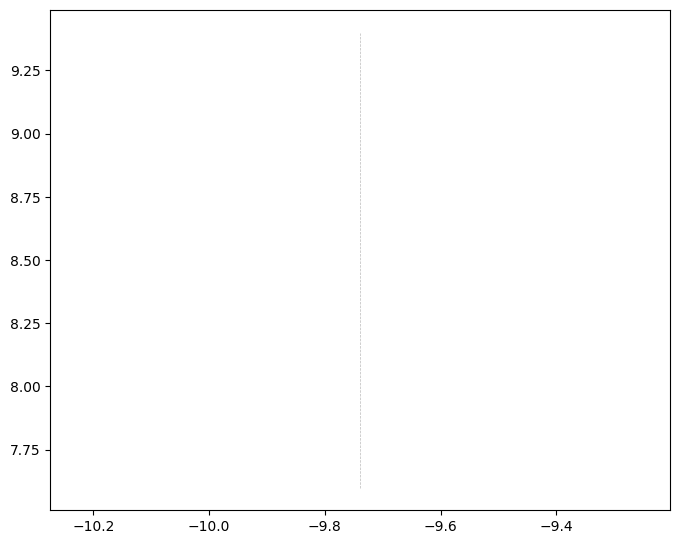

In [95]:
explanation = shap.Explanation(
    values=shap_values[sample_idx].values,  # Valeurs SHAP (impact de chaque feature)
    base_values=shap_values[sample_idx].base_values,  # Valeur de base (probabilité de départ)
    data=sample.values,  # Valeurs des features pour cet exemple
    feature_names=X[features].columns.tolist()  # Noms des features
)

# Affichage
print(explanation)
shap.initjs()
shap.waterfall_plot(explanation)

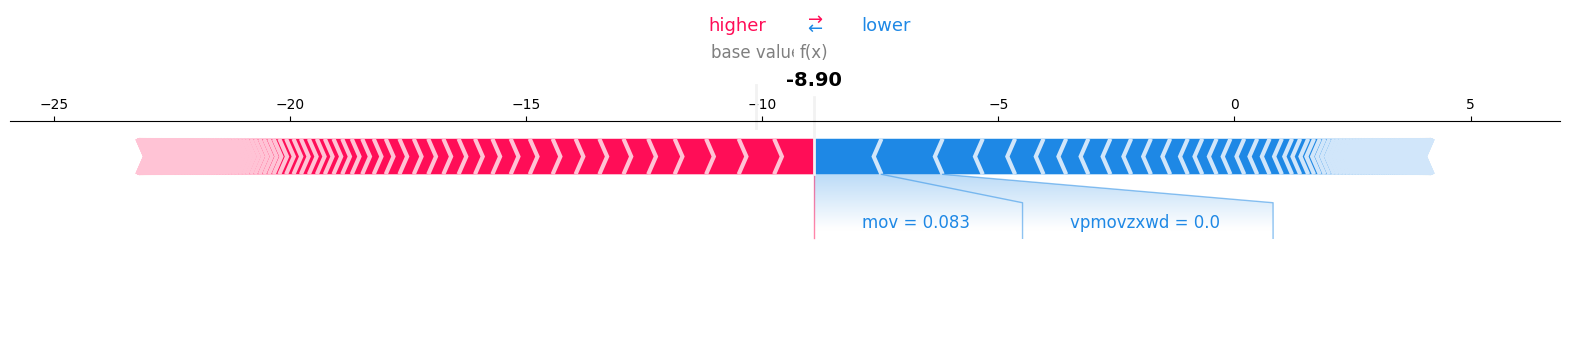

In [93]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[15].values, sample.apply(lambda x : x.round(3)), matplotlib=True)

In [82]:
sample

,file_size,num_nodes,num_edges,num_loops,num_calls,num_jumps,num_ret,num_conditional_jumps,average_in_degree,max_in_degree,...,vcomiss,cmppd,phsubw,pcmpgtd,setg,fldl2t,kxorb,vplzcntd,vpermps,palignr
0,103576,1112,1740,14,270,230,69,428,1.564748,77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
X

,file_size,num_nodes,num_edges,num_loops,num_calls,num_jumps,num_ret,num_conditional_jumps,average_in_degree,max_in_degree,...,vcomiss,cmppd,phsubw,pcmpgtd,setg,fldl2t,kxorb,vplzcntd,vpermps,palignr
0,103576,1112,1740,14,270,230,69,428,1.564748,77,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,15984,161,245,4,6,21,4,84,1.521739,17,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,303471,4607,7413,3,2485,641,470,526,1.609073,1054,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,11229717,102070,182474,65,60104,4938,3941,24487,1.787734,51208,...,0.0,0.0,0.0,0.0,0.000036,0.0,0.0,0.0,0.0,0.0
4,3728521,42349,64677,88,13625,3474,3590,13004,1.527238,2081,...,0.0,0.0,0.0,0.0,0.000044,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23097,313243,2815,3251,0,2,1,3,490,1.154885,4,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
23098,18379,295,476,0,182,13,44,44,1.613559,161,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
23099,3590439,42762,49884,0,2856,1408,856,5032,1.166550,421,...,0.0,0.0,0.0,0.0,0.013144,0.0,0.0,0.0,0.0,0.0
23100,55570,586,692,4,34,19,31,207,1.180887,45,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
# From my test
# class_weight balanced always improved the f1 score at first, i never change it after that
# max_depth 8 is better than None, and 6 or 7
# learning rate 0.25 is better than 0.2 and 0.3, but it was tested long ago
# max_features 0.8 better than 1, and slighlty better than 0.6. Decreasing it could be an idea, in addition to adding more tfidf variables
# max iter 400 better than lower value and 500. Greater value may not help due to the validation fraction at none
# max_leaf_nodes 53 is better than lower value 42 and 34, and better than 70. Some more testing could be interessting, it was also tested long ago
# min_samples_leaf is the last addition, 20 by default before, 60 was better, and now 140 is the best value. 
# A gridsearch with the above parameters and a choice of 60, 100, 140, 200 return 140 as the best value. A value between 140 and 200 could improve the result
# An other idea, iterate over a list of random seed to see if one is slightly better in order to gain 0.1 

best_config = {
    'estimator__class_weight': 'balanced',
    'estimator__learning_rate': 0.25,
    'estimator__max_depth': 8,
    'estimator__max_features': 0.8,
    'estimator__max_iter': 400,
    'estimator__max_leaf_nodes': 53,
    'estimator__min_samples_leaf': 140
}

### Submission 

In [40]:
final_test = pd.read_csv(f'{data_folder}/test_set_metadata_to_predict.csv', sep=';')

In [41]:
final_test_pred = best_model.predict(all_test[features])
all_test_with_pred = pd.concat([all_test, pd.DataFrame(final_test_pred, columns=y_train.columns)], axis=1)

In [42]:
all_test_with_pred_filter = pd.merge(final_test["name"], all_test_with_pred.drop(model_col+['average_out_degree', 'min_out_degree', 'min_in_degree'], axis=1), how='inner', on="name")

In [43]:
all_test_with_pred_filter

,name,64-bit execution via heavens gate,64bits,PEB access,accept command line arguments,access the Windows event log,act as TCP client,allocate RW memory,allocate RWX memory,allocate memory,...,winzip,wise,worm,write and execute a file,write clipboard data,write file on Linux,write file on Windows,write pipe,xorcrypt,yoda
0,95ff2b3fd399984950293194a717d404bc4e9e3aa0296f...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4216c07609bb5b89f32d9b559494848a0f5411d1e2d3cf...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2518f84c015a5795bdb2597d580ab7df8e0bfa4b6543c6...,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,243268c658456d9b8ec968c088c4f3c7cb976df92a4b99...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,533c09cb9b49c10494337d3eb7d2919c2c656b37f554fb...,0,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,7f0a7ccc2abe273330885020f6dc5f116fe83535838b65...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2996,a188ff24aec863479408cee54b337a2fce25b9372ba557...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2997,11bf54ba134bfcf242e6c841ae56f44883cdf1b45fa24c...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2998,7a8862b047f38a1f9ff37b6d1fa114f61bcb7ad6415bed...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [44]:
all_test_with_pred_filter.to_excel('results_v21.xlsx', index=False)